In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
!mkdir -p .data/multi30k
!git clone https://github.com/multi30k/dataset.git

!cp dataset/data/task1/raw/train.fr.gz .data/multi30k
!cp dataset/data/task1/raw/train.en.gz .data/multi30k

!cp dataset/data/task1/raw/val.fr.gz .data/multi30k
!cp dataset/data/task1/raw/val.en.gz .data/multi30k

!cp dataset/data/task1/raw/test_2016_flickr.fr.gz .data/multi30k
!cp dataset/data/task1/raw/test_2016_flickr.en.gz .data/multi30k

!gzip -d .data/multi30k/train.fr.gz
!gzip -d .data/multi30k/train.en.gz

!gzip -d .data/multi30k/val.fr.gz
!gzip -d .data/multi30k/val.en.gz

!gzip -d .data/multi30k/test_2016_flickr.fr.gz
!gzip -d .data/multi30k/test_2016_flickr.en.gz

!mv .data/multi30k/test_2016_flickr.fr .data/multi30k/test2016.fr
!mv .data/multi30k/test_2016_flickr.en .data/multi30k/test2016.en

!python3 -m spacy download fr_core_news_sm
!python3 -m spacy download en_core_web_sm

fatal: destination path 'dataset' already exists and is not an empty directory.
gzip: .data/multi30k/train.fr already exists; do you wish to overwrite (y or n)? y
gzip: .data/multi30k/train.en already exists; do you wish to overwrite (y or n)? y
gzip: .data/multi30k/val.fr already exists; do you wish to overwrite (y or n)? y
gzip: .data/multi30k/val.en already exists; do you wish to overwrite (y or n)? y
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
def tokenize_fr(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

spacy_fr = spacy.load('fr_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

SRC = Field(tokenize=tokenize_fr, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True, 
            batch_first=True)

TRG = Field(tokenize=tokenize_en, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True, 
            batch_first=True)

train_data, valid_data, test_data = Multi30k.splits(exts=('.fr', '.en'), fields=(SRC, TRG))

SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

KeyboardInterrupt: ignored

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size=BATCH_SIZE,
     device=device)

NameError: ignored

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + torch.tensor(self.pe[:, :x.size(1)], requires_grad=False)
        
        return self.dropout(x)

'\nclass PositionalEncoding(nn.Module):\n    "Implement the PE function."\n    def __init__(self, d_model, dropout, max_len=5000):\n        super(PositionalEncoding, self).__init__()\n        self.dropout = nn.Dropout(p=dropout)\n        \n        # Compute the positional encodings once in log space.\n        pe = torch.zeros(max_len, d_model)\n        position = torch.arange(0, max_len).unsqueeze(1)\n        div_term = torch.exp(torch.arange(0, d_model, 2) *\n                             -(math.log(10000.0) / d_model))\n        pe[:, 0::2] = torch.sin(position * div_term)\n        pe[:, 1::2] = torch.cos(position * div_term)\n        pe = pe.unsqueeze(0)\n        self.register_buffer(\'pe\', pe)\n        \n    def forward(self, x):\n        x = x + Variable(self.pe[:, :x.size(1)], \n                         requires_grad=False)\n        return self.dropout(x)\n'

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        # self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.pos_embedding = PositionalEncoding(max_length, dropout)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            # mask == True인 element를 -1e10으로 대체
            # 여기에서는 mask가 0이면 element를 -1e10
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        # self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.pos_embedding = PositionalEncoding(max_length, dropout)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        # query가 trg 로 바뀌었다는 점 주목
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        # 이렇게 구현하면 매 레이어에서 encoding block의 결과를 가져오는 것으로 보임.
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]

        # lower triangular shape 반환
        # 즉 하나씩 밀어가면서 mask를 제거하는 효과
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
        
        # bit 연산 (Binary AND)
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3 
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:

        nn.init.xavier_uniform_(m.weight.data)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

model.apply(initialize_weights);
print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
# https://stackoverflow.com/questions/55681502/label-smoothing-in-pytorch

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean', ignore_index=None):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
        self.ignore_index = ignore_index

    @staticmethod
    def linear_combination(x, y, epsilon):
        return epsilon * x + (1 - epsilon) * y

    @staticmethod
    def reduce_loss(loss, reduction='mean'):
        return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        if self.ignore_index:
            nll = F.nll_loss(log_preds, target, reduction=self.reduction, ignore_index=self.ignore_index)
        else:
            nll = F.nll_loss(log_preds, target, reduction=self.reduction)
            
        return linear_combination(loss / n, nll, self.epsilon)

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# criterion = nn.CrossEntropyoss(ignore_index = TRG_PAD_IDX)
criterion = LabelSmoothingCrossEntropy(ignore_index=TRG_PAD_INDEX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
# https://github.com/ildoonet/pytorch-gradual-warmup-lr/blob/6b5e8953a80aef5b324104dc0c2e9b8c34d622bd/warmup_scheduler/scheduler.py#L5

class GradualWarmupScheduler(_LRScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False

        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        # warm up 종료 판단
        if self.last_epoch > self.total_epoch:
            # 뒤에 다른 lr scheduler 가 있느냐?
            if self.after_scheduler:
                # after lr scheduler의 base lr 설정하고 함수 종료
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            # 다른 lr scheduler가 없기 때문에 base lr 에 multiplier를 곱해서 리턴
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    # lr scheduler 중 reduce lr on plateau는 함수 epoch 에 마지막에 호출되는 반면 다른 lr scheduler는 epoch에 시작에 호출된다고 함
    # 이 때문에 reduce lr on plateau를 다른 함수로 분기시킴
    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

In [ ]:
N_EPOCHS = 10
CLIP = 1

scheduler_plateau = ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=10)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler_plateau)

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    scheduler_warmup.step(epoch)

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | Learning Rate: {optimizer.param_group[0]['lr']}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 10s
	Train Loss: 4.189 | Train PPL:  65.946
	 Val. Loss: 2.874 |  Val. PPL:  17.704
Epoch: 02 | Time: 0m 10s
	Train Loss: 2.593 | Train PPL:  13.368
	 Val. Loss: 2.039 |  Val. PPL:   7.686
Epoch: 03 | Time: 0m 10s
	Train Loss: 1.951 | Train PPL:   7.037
	 Val. Loss: 1.691 |  Val. PPL:   5.426
Epoch: 04 | Time: 0m 10s
	Train Loss: 1.589 | Train PPL:   4.900
	 Val. Loss: 1.500 |  Val. PPL:   4.480
Epoch: 05 | Time: 0m 10s
	Train Loss: 1.349 | Train PPL:   3.855
	 Val. Loss: 1.394 |  Val. PPL:   4.032
Epoch: 06 | Time: 0m 10s
	Train Loss: 1.173 | Train PPL:   3.230
	 Val. Loss: 1.329 |  Val. PPL:   3.776
Epoch: 07 | Time: 0m 10s
	Train Loss: 1.033 | Train PPL:   2.810
	 Val. Loss: 1.315 |  Val. PPL:   3.723
Epoch: 08 | Time: 0m 10s
	Train Loss: 0.926 | Train PPL:   2.523
	 Val. Loss: 1.289 |  Val. PPL:   3.631
Epoch: 09 | Time: 0m 10s
	Train Loss: 0.833 | Train PPL:   2.300
	 Val. Loss: 1.285 |  Val. PPL:   3.615
Epoch: 10 | Time: 0m 10s
	Train Loss: 0.755 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.238 | Test PPL:   3.447 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('fr_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['une', 'femme', 'avec', 'un', 'gros', 'sac', 'passe', 'par', 'une', 'porte', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'bag', 'passes', 'by', 'a', 'door', '.', '<eos>']


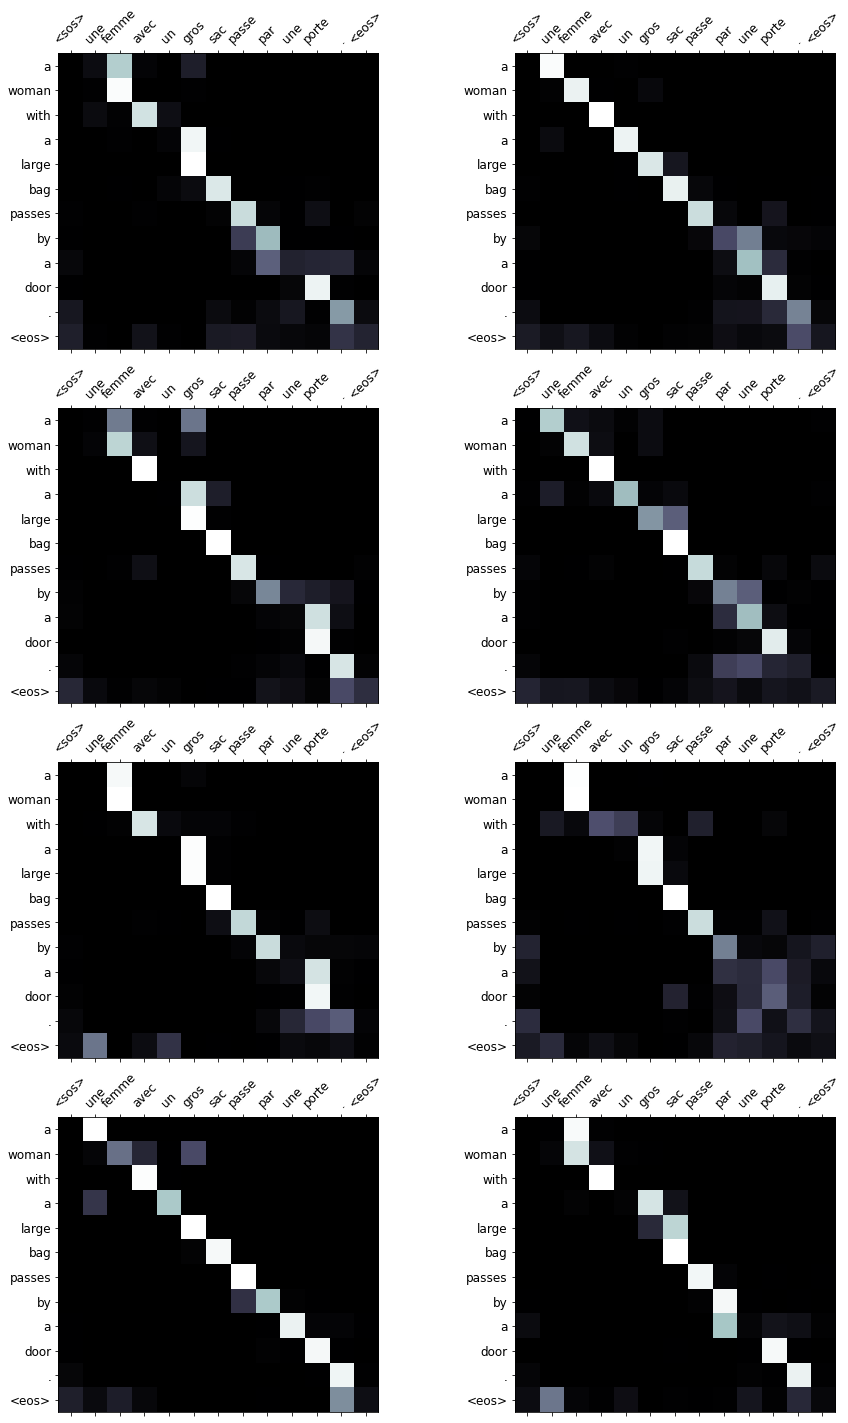

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['un', 'chien', 'brun', 'court', 'après', 'le', 'chien', 'noir', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'chases', 'the', 'black', 'dog', '.', '<eos>']


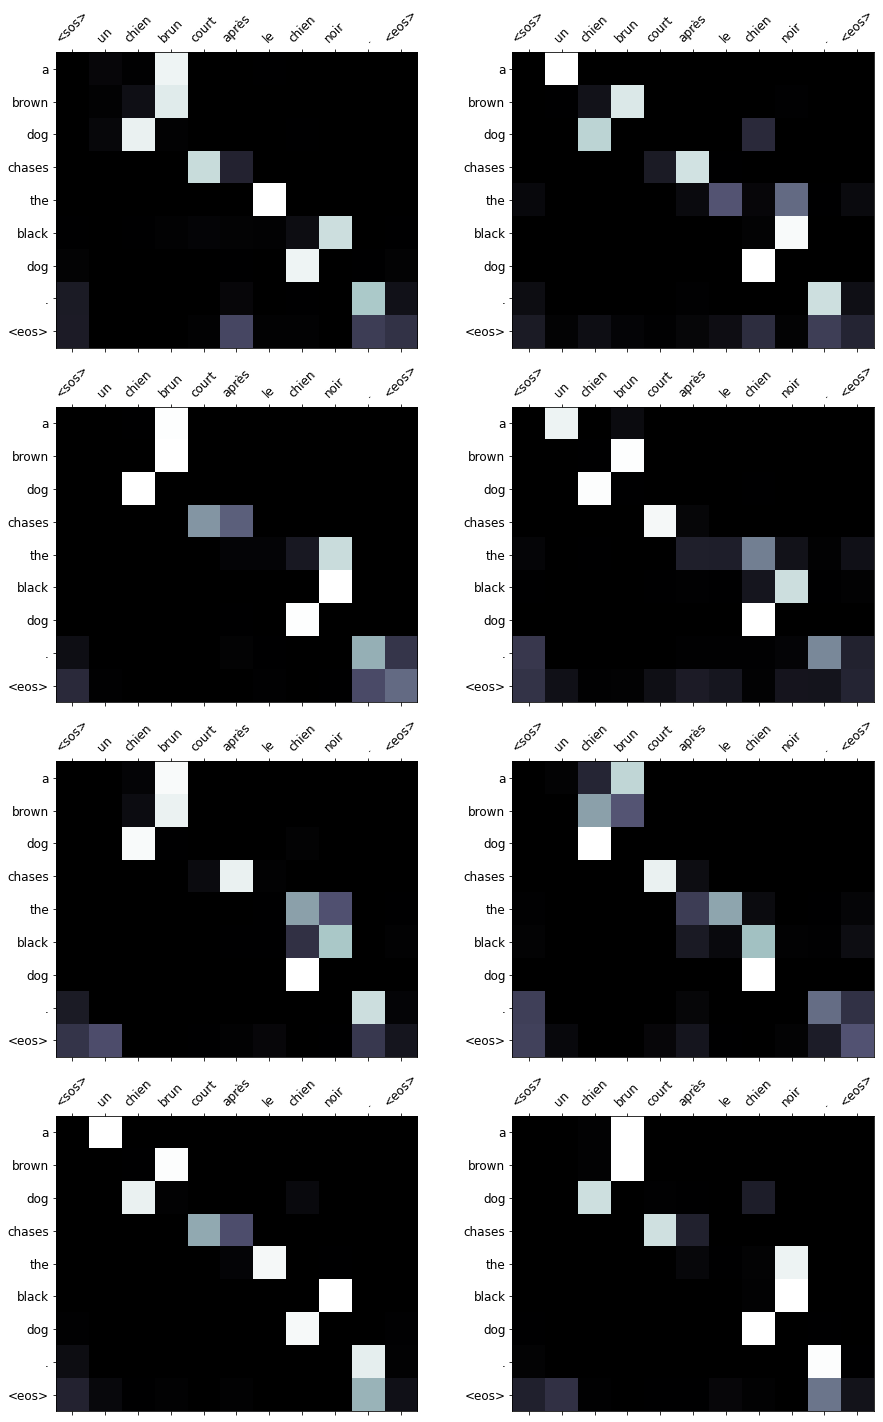

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['une', 'mère', 'et', 'son', 'jeune', 'fils', 'profitant', "d'", 'une', 'belle', 'journée', 'dehors', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


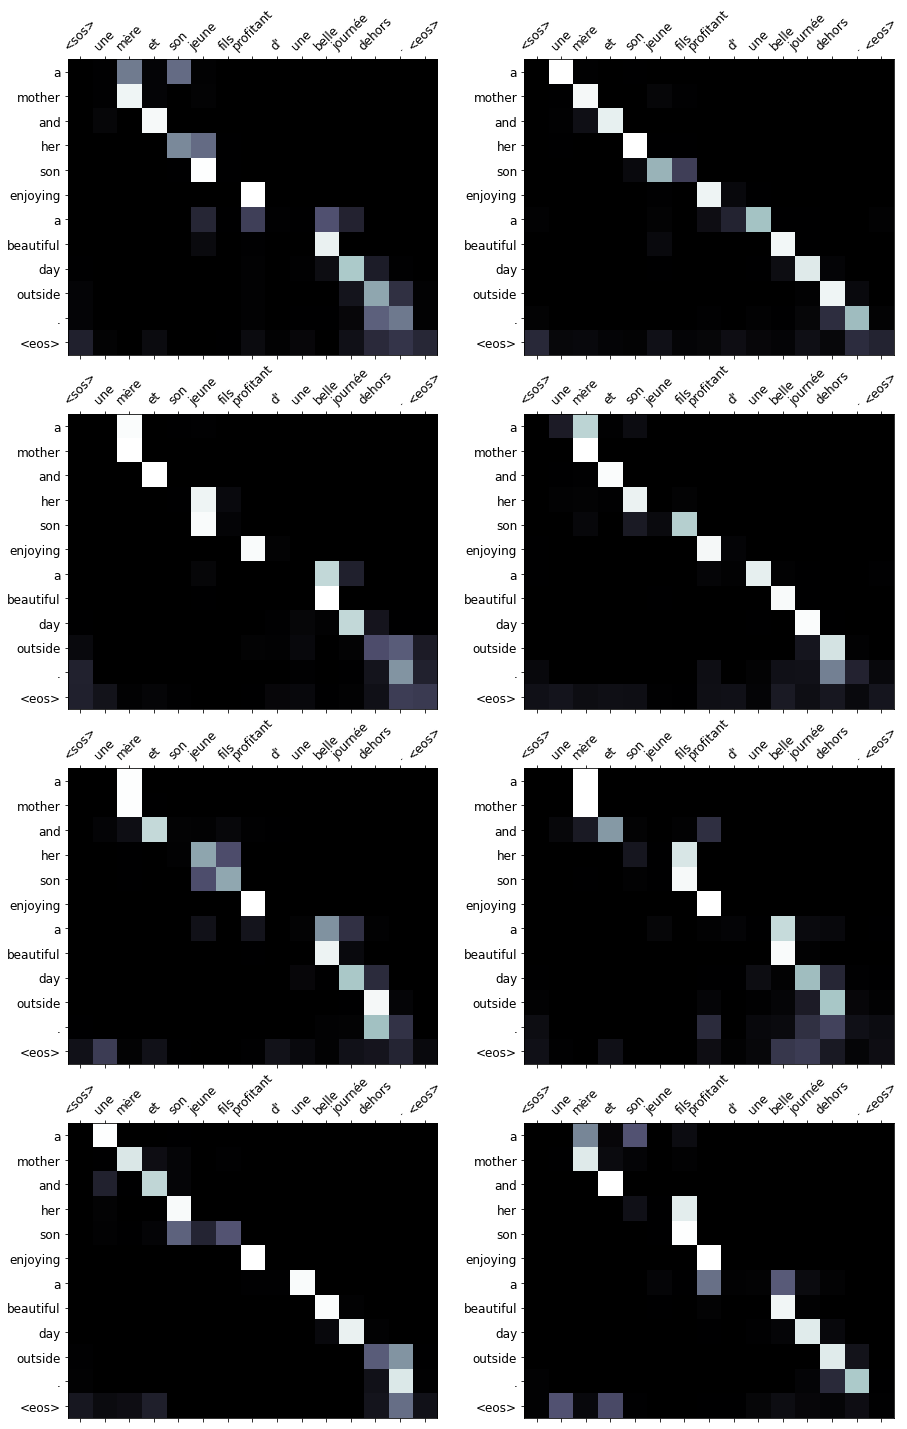

In [ ]:
display_attention(src, translation, attention)

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 48.08


In [ ]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)